# Notebook 9 — Two-Way DKL: Joint Race × Income Segregation

The **2-way DKL** extends the one-way metric by measuring how unevenly *joint*
(race, income) groups are distributed across census tracts within a metropolitan area.

## Formula

For each tract *i* and (race=*j*, income=*k*) cell:

$$\text{DKL}_{2\text{-way}}(i) = \sum_{j,k} p_{yz,i} \log_2 \frac{p_{yz,i}}{p_{yz}}$$

where $p_{yz,i} = P(\text{race}=j, \text{income}=k \mid \text{tract}=i)$ and
$p_{yz} = P(\text{race}=j, \text{income}=k)$ in the MSA.

## Decomposition

$$\text{Residual}(i) = \text{DKL}_{2\text{-way}}(i) - \text{DKL}_{\text{race}}(i) - \text{DKL}_{\text{income}}(i)$$

The residual captures sorting specific to particular *race × income* combinations —
beyond what either race or income sorting alone predicts.

**Data**: ACS 5-year 2015 and 2020, tables B19001A–I (household income by race/ethnicity)
at **census tract** level (cross-tabulations not available at block group level).

**Cities**: Atlanta, Chicago, Houston, New York

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from census import Census

warnings.filterwarnings('ignore')

NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CENSUS_API_KEY, CITIES
from utils.cbsa_xwalk import get_cbsa_xwalk

sns.set_theme(style='whitegrid', font_scale=0.95)
YEARS = [2015, 2020]

print(f'DATA_DIR : {DATA_DIR}')
print(f'CITIES   : {CITIES}')
print(f'YEARS    : {YEARS}')

DATA_DIR : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
CITIES   : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']
YEARS    : [2015, 2020]


In [2]:
# ── Config ────────────────────────────────────────────────────────────────────

# ACS tables B19001A-I: household income by race/ethnicity
RACE_TABLES = {
    'White (non-Hisp.)': 'B19001H',
    'Black':             'B19001B',
    'Native American':   'B19001C',
    'Asian':             'B19001D',
    'Pacific Islander':  'B19001E',
    'Other race':        'B19001F',
    'Two or more':       'B19001G',
    'Hispanic/Latino':   'B19001I',
}

INCOME_ITEMS = [f'{i:03d}' for i in range(2, 18)]   # 002–017 (excludes total)

INCOME_LABELS = {
    '002': '< $10K',    '003': '$10–15K',  '004': '$15–20K',  '005': '$20–25K',
    '006': '$25–30K',   '007': '$30–35K',  '008': '$35–40K',  '009': '$40–45K',
    '010': '$45–50K',   '011': '$50–60K',  '012': '$60–75K',  '013': '$75–100K',
    '014': '$100–125K', '015': '$125–150K','016': '$150–200K','017': '> $200K',
}

RACE_COLORS = {
    'White (non-Hisp.)': '#4393c3',
    'Black':             '#d6604d',
    'Hispanic/Latino':   '#74c476',
    'Asian':             '#fd8d3c',
    'Two or more':       '#9e9ac8',
    'Native American':   '#bdbdbd',
    'Pacific Islander':  '#a1d99b',
    'Other race':        '#bcbddc',
}

CITY_SHORT = {c: c.split(',')[0].split('-')[0].strip() for c in CITIES}
print('City labels:', list(CITY_SHORT.values()))

City labels: ['Chicago', 'Houston', 'Atlanta', 'New York']


In [3]:
# ── CBSA crosswalk → identify states needed ───────────────────────────────────

cbsa_xwalk = get_cbsa_xwalk(2020)

primary_names = [c.split(',')[0] for c in CITIES]
city_counties = cbsa_xwalk[
    cbsa_xwalk['cbsa_title'].str.contains('|'.join(primary_names), case=False, na=False)
].copy()

study_state_fips = sorted(city_counties['county_fips'].str[:2].unique().tolist())
print(f'States to download ({len(study_state_fips)}): {study_state_fips}')
print(city_counties.groupby('cbsa_title').size().rename('n_counties'))

States to download (8): ['13', '17', '18', '34', '36', '42', '48', '55']
cbsa_title
Atlanta-Sandy Springs-Alpharetta, GA     29
Chicago-Naperville-Elgin, IL-IN-WI       14
Houston-The Woodlands-Sugar Land, TX      9
New York-Newark-Jersey City, NY-NJ-PA    23
Name: n_counties, dtype: int64


In [4]:
# ── Download B19001A-I at tract level for each year (cached) ──────────────────

def _build_variables():
    return [
        f'{table}_{item}'
        for table in RACE_TABLES.values()
        for item in INCOME_ITEMS
    ]


def _fetch_state(c_api, state_fips, variables, year):
    chunk_size = 45
    chunks = [variables[i:i+chunk_size] for i in range(0, len(variables), chunk_size)]
    dfs = []
    for chunk in chunks:
        api_vars = [v + 'E' for v in chunk]
        rows = c_api.acs5.state_county_tract(
            fields=['NAME'] + api_vars,
            state_fips=state_fips,
            county_fips=Census.ALL,
            tract=Census.ALL,
            year=year,
        )
        df = pd.DataFrame(rows)
        df = df.rename(columns={v + 'E': v for v in chunk})
        dfs.append(df)

    result = dfs[0]
    for extra in dfs[1:]:
        shared = [c for c in extra.columns if c in result.columns and c not in variables]
        result = result.merge(extra[shared + [v for v in extra.columns if v in variables]],
                              on=shared, how='left')
    result['tract_fips'] = (
        result['state'].astype(str).str.zfill(2) +
        result['county'].astype(str).str.zfill(3) +
        result['tract'].astype(str).str.zfill(6)
    )
    return result


def download_joint_data(year, state_fips_list, api_key):
    c_api = Census(api_key)
    variables = _build_variables()
    frames = []
    for sf in state_fips_list:
        print(f'  State {sf} …', end=' ', flush=True)
        try:
            df = _fetch_state(c_api, sf, variables, year)
            for v in variables:
                if v in df.columns:
                    df[v] = pd.to_numeric(df[v], errors='coerce').fillna(0).clip(lower=0)
                else:
                    df[v] = 0.0
            id_cols = ['tract_fips']
            long = df[id_cols + variables].melt(
                id_vars=id_cols, var_name='variable', value_name='estimate'
            )
            long['race_group']   = long['variable'].apply(
                lambda v: next(k for k, t in RACE_TABLES.items() if t == v[:7])
            )
            long['income_item']  = long['variable'].str[-3:]
            long['income_label'] = long['income_item'].map(INCOME_LABELS)
            frames.append(long[['tract_fips','race_group','income_item','income_label','estimate']])
            print(f'{len(df):,} tracts')
        except Exception as e:
            print(f'ERROR: {e}')
    return pd.concat(frames, ignore_index=True)


# Download / load each year, then combine
frames_by_year = {}
for year in YEARS:
    cache = DATA_DIR / 'two_way_dkl' / f'joint_race_income_tract_{year}.parquet'
    cache.parent.mkdir(parents=True, exist_ok=True)
    if cache.exists():
        print(f'Year {year}: loading from cache …')
        frames_by_year[year] = pd.read_parquet(cache)
    else:
        print(f'Year {year}: downloading …')
        df = download_joint_data(year, study_state_fips, CENSUS_API_KEY)
        df.to_parquet(cache, index=False)
        frames_by_year[year] = df
    print(f'  {len(frames_by_year[year]):,} rows')

joint_raw_all = pd.concat(
    [df.assign(year=yr) for yr, df in frames_by_year.items()],
    ignore_index=True
)
print(f'\nCombined: {len(joint_raw_all):,} rows')
joint_raw_all.head(3)

Year 2015: downloading …
  State 13 … 

1,969 tracts
  State 17 … 

3,123 tracts
  State 18 … 

1,511 tracts
  State 34 … 

2,010 tracts
  State 36 … 

4,918 tracts
  State 42 … 

3,218 tracts
  State 48 … 

5,265 tracts
  State 55 … 

1,409 tracts


  2,998,144 rows
Year 2020: loading from cache …


  3,485,824 rows



Combined: 6,483,968 rows


tract_fips         race_group income_item income_label  estimate  year
0  13135050531  White (non-Hisp.)         002       < $10K       0.0  2015
1  13135050532  White (non-Hisp.)         002       < $10K      37.0  2015
2  13135050533  White (non-Hisp.)         002       < $10K      59.0  2015

In [5]:
# ── Filter to study cities + attach CBSA info ─────────────────────────────────

county_cbsa = cbsa_xwalk[['county_fips','cbsa_fips','cbsa_title']].drop_duplicates()

joint_all = joint_raw_all.copy()
joint_all['county_fips'] = joint_all['tract_fips'].str[:5]
joint_all = joint_all.merge(county_cbsa, on='county_fips', how='inner')

mask = joint_all['cbsa_title'].str.contains(
    '|'.join(primary_names), case=False, na=False
)
joint_all = joint_all[mask].copy()

def _city_label(title):
    for c in CITIES:
        if c.split(',')[0].lower() in title.lower():
            return CITY_SHORT[c]
    return title.split(',')[0]

joint_all['city_label'] = joint_all['cbsa_title'].apply(_city_label)

income_order = [INCOME_LABELS[k] for k in sorted(INCOME_LABELS)]
joint_all['income_label'] = pd.Categorical(joint_all['income_label'], categories=income_order, ordered=True)

# Working alias used throughout downstream cells
joint = joint_all

print(f'Filtered rows: {len(joint_all):,}')
print(joint_all.groupby(['year','city_label']).agg(tracts=('tract_fips','nunique')).to_string())

Filtered rows: 2,454,272
                 tracts
year city_label        
2015 Atlanta        951
     Chicago       2215
     Houston       1072
     New York      4542
2020 Atlanta       1500
     Chicago       2335
     Houston       1606
     New York      4953


In [6]:
# ── Compute tract- and CBSA-level aggregations (year-aware) ───────────────────

joint['tract_joint']  = joint['estimate']
joint['tract_total']  = joint.groupby(['year','tract_fips'])['estimate'].transform('sum')
joint['tract_race']   = joint.groupby(['year','tract_fips','race_group'])['estimate'].transform('sum')
joint['tract_income'] = joint.groupby(['year','tract_fips','income_item'])['estimate'].transform('sum')

joint['cbsa_joint']   = joint.groupby(['year','cbsa_fips','race_group','income_item'])['estimate'].transform('sum')
joint['cbsa_total']   = joint.groupby(['year','cbsa_fips'])['estimate'].transform('sum')
joint['cbsa_race']    = joint.groupby(['year','cbsa_fips','race_group'])['estimate'].transform('sum')
joint['cbsa_income']  = joint.groupby(['year','cbsa_fips','income_item'])['estimate'].transform('sum')

print('Aggregations done. Sample:')
joint[['year','tract_fips','race_group','income_item','estimate','tract_total','cbsa_total']].head(5)

Aggregations done. Sample:


year   tract_fips         race_group income_item  estimate  tract_total  \
0  2015  13135050531  White (non-Hisp.)         002       0.0       2687.0   
1  2015  13135050532  White (non-Hisp.)         002      37.0       2855.0   
2  2015  13135050533  White (non-Hisp.)         002      59.0       2848.0   
3  2015  13135050534  White (non-Hisp.)         002      15.0       3119.0   
4  2015  13135050535  White (non-Hisp.)         002       8.0       2646.0   

   cbsa_total  
0   2019851.0  
1   2019851.0  
2   2019851.0  
3   2019851.0  
4   2019851.0

In [7]:
# ── Compute 2-way DKL and 1-way components (year-aware) ───────────────────────

def safe_log2(num, denom):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where((num > 0) & (denom > 0), num / denom, np.nan)
        return np.where(np.isfinite(ratio) & (ratio > 0), np.log2(ratio), 0.0)


T  = joint['tract_total'].values
CT = joint['cbsa_total'].values

p_yjzk_ni = np.where(T > 0,  joint['tract_joint'].values  / T,  0.0)
p_yjzk    = np.where(CT > 0, joint['cbsa_joint'].values   / CT, 0.0)
p_yj_ni   = np.where(T > 0,  joint['tract_race'].values   / T,  0.0)
p_yj      = np.where(CT > 0, joint['cbsa_race'].values    / CT, 0.0)
p_zk_ni   = np.where(T > 0,  joint['tract_income'].values / T,  0.0)
p_zk      = np.where(CT > 0, joint['cbsa_income'].values  / CT, 0.0)

joint['dkl_2way_jk']  = p_yjzk_ni * safe_log2(p_yjzk_ni, p_yjzk)
joint['dkl_race_j']   = p_yj_ni   * safe_log2(p_yj_ni,   p_yj)
joint['dkl_income_k'] = p_zk_ni   * safe_log2(p_zk_ni,   p_zk)

# ── Aggregate to tract level ──
tract_dkl_all = (
    joint.groupby(['year','tract_fips','cbsa_fips','cbsa_title','city_label'])
    .agg(dkl_2way=('dkl_2way_jk','sum'), tract_total=('tract_total','first'))
    .reset_index()
)

race_1way = (
    joint.drop_duplicates(['year','tract_fips','race_group'])
    .groupby(['year','tract_fips'])['dkl_race_j'].sum()
    .rename('dkl_1way_race')
)
income_1way = (
    joint.drop_duplicates(['year','tract_fips','income_item'])
    .groupby(['year','tract_fips'])['dkl_income_k'].sum()
    .rename('dkl_1way_income')
)

tract_dkl_all = (
    tract_dkl_all
    .set_index(['year','tract_fips'])
    .join(race_1way)
    .join(income_1way)
    .reset_index()
)
tract_dkl_all['residual'] = (
    tract_dkl_all['dkl_2way']
    - tract_dkl_all['dkl_1way_race']
    - tract_dkl_all['dkl_1way_income']
)

# Convenience alias: 2020-only slice
tract_dkl = tract_dkl_all[tract_dkl_all['year'] == 2020].copy()

print(f'Tract-level DKL: {len(tract_dkl_all):,} rows | years: {sorted(tract_dkl_all["year"].unique())}')
tract_dkl_all.groupby(['year','city_label'])[
    ['dkl_2way','dkl_1way_race','dkl_1way_income','residual']
].median().round(4)

Tract-level DKL: 19,174 rows | years: [np.int64(2015), np.int64(2020)]


dkl_2way  dkl_1way_race  dkl_1way_income  residual
year city_label                                                    
2015 Atlanta       0.9893         0.3906           0.2572    0.2965
     Chicago       1.0013         0.4449           0.2738    0.2516
     Houston       1.0936         0.4081           0.3123    0.3278
     New York      1.1492         0.5609           0.2917    0.3097
2020 Atlanta       1.4099         0.4570           0.4474    0.4408
     Chicago       1.1445         0.4562           0.3360    0.3315
     Houston       1.5631         0.4627           0.4984    0.5256
     New York      1.3246         0.5603           0.3615    0.4089

In [8]:
# ── City-level summary: population-weighted means ─────────────────────────────

def weighted_mean(df, col, weight='tract_total'):
    w = df[weight].clip(lower=0)
    return (df[col] * w).sum() / w.sum() if w.sum() > 0 else np.nan

summary_all = (
    tract_dkl_all.groupby(['year','city_label'])
    .apply(lambda g: pd.Series({
        'DKL 2-way (joint race×income)': weighted_mean(g, 'dkl_2way'),
        'DKL 1-way race':               weighted_mean(g, 'dkl_1way_race'),
        'DKL 1-way income':             weighted_mean(g, 'dkl_1way_income'),
        'Residual (interaction)':       weighted_mean(g, 'residual'),
        'n_tracts':                     len(g),
    }))
    .reset_index()
)

# Convenience alias: 2020-only slice
summary = summary_all[summary_all['year'] == 2020].drop(columns='year').reset_index(drop=True)

print('Population-weighted mean DKL by city and year:')
summary_all.set_index(['year','city_label']).round(4)

Population-weighted mean DKL by city and year:


DKL 2-way (joint race×income)  DKL 1-way race  \
year city_label                                                  
2015 Atlanta                            1.0394          0.4468   
     Chicago                            1.1826          0.6247   
     Houston                            1.1227          0.4480   
     New York                           1.2711          0.6455   
2020 Atlanta                            1.4396          0.5179   
     Chicago                            1.3331          0.6262   
     Houston                            1.5731          0.5026   
     New York                           1.4413          0.6357   

                 DKL 1-way income  Residual (interaction)  n_tracts  
year city_label                                                      
2015 Atlanta               0.2987                  0.2939     951.0  
     Chicago               0.3136                  0.2444    2215.0  
     Houston               0.3550                  0.3198    1072.0  
     New York              0.3505                  0.2752    4542.0  
2020 Atlanta               0.4749                  0.4467    1500.0  
     Chicago               0.3773                  0.3296    2335.0  
     Houston               0.5379                  0.5325    1606.0  
     New York              0.4218                  0.3838    4953.0

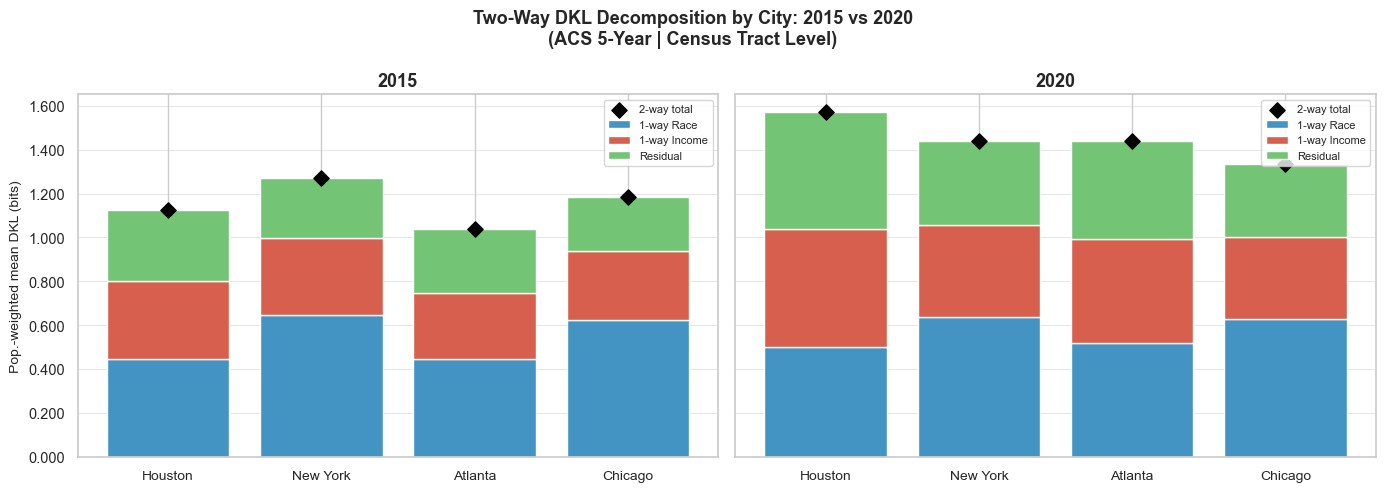

In [9]:
# ── Plot 1: City comparison — 2015 vs 2020 stacked bars ──────────────────────

metric_cols   = ['DKL 1-way race', 'DKL 1-way income', 'Residual (interaction)']
metric_labels = ['1-way Race', '1-way Income', 'Residual']
colors        = ['#4393c3', '#d6604d', '#74c476']

# City order by 2020 2-way DKL descending
city_order = (
    summary_all[summary_all['year'] == 2020]
    .sort_values('DKL 2-way (joint race×income)', ascending=False)['city_label']
    .tolist()
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, year in zip(axes, YEARS):
    sub = summary_all[summary_all['year'] == year].set_index('city_label')
    x = np.arange(len(city_order))
    bottom = np.zeros(len(city_order))
    for col, color, label in zip(metric_cols, colors, metric_labels):
        vals = np.array([sub.loc[c, col] if c in sub.index else 0 for c in city_order])
        ax.bar(x, vals, bottom=bottom, color=color, edgecolor='white', label=label)
        bottom += vals
    totals = [
        sub.loc[c, 'DKL 2-way (joint race×income)'] if c in sub.index else 0
        for c in city_order
    ]
    ax.scatter(x, totals, color='black', zorder=5, s=60, marker='D', label='2-way total')
    ax.set_xticks(x)
    ax.set_xticklabels(city_order, fontsize=10)
    ax.set_title(f'{year}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
    ax.grid(axis='y', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

axes[0].set_ylabel('Pop.-weighted mean DKL (bits)', fontsize=10)
fig.suptitle(
    'Two-Way DKL Decomposition by City: 2015 vs 2020\n'
    '(ACS 5-Year | Census Tract Level)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

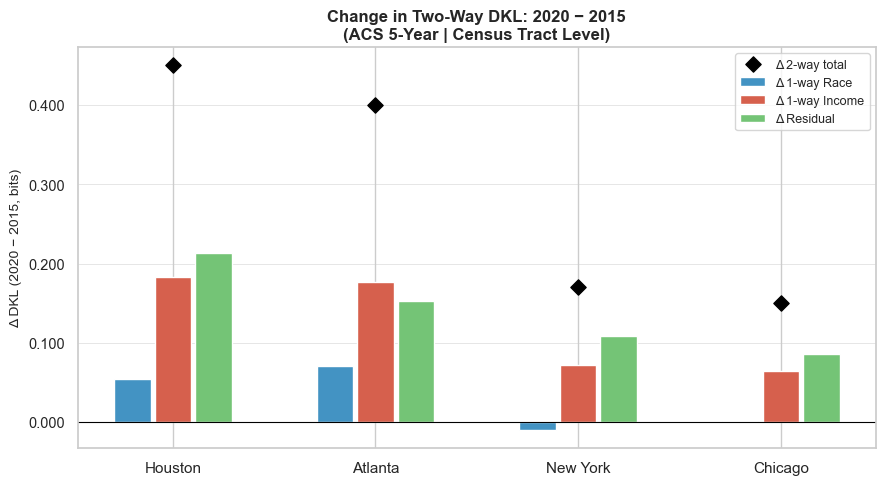

In [10]:
# ── Plot 2: Change in DKL — 2020 minus 2015 ──────────────────────────────────

pivot_15 = summary_all[summary_all['year'] == 2015].set_index('city_label')
pivot_20 = summary_all[summary_all['year'] == 2020].set_index('city_label')
common   = sorted(set(pivot_15.index) & set(pivot_20.index))
delta    = (pivot_20.loc[common] - pivot_15.loc[common]).drop(columns=['n_tracts'])

delta_order = delta.sort_values('DKL 2-way (joint race×income)', ascending=False).index.tolist()

fig, ax = plt.subplots(figsize=(9, 5))
x     = np.arange(len(delta_order))
bar_w = 0.2

for i, (col, color, label) in enumerate(zip(metric_cols, colors, metric_labels)):
    ax.bar(
        x + (i - 1) * bar_w,
        delta.loc[delta_order, col],
        width=bar_w * 0.9, color=color, label=f'Δ {label}', edgecolor='white'
    )

ax.scatter(
    x, delta.loc[delta_order, 'DKL 2-way (joint race×income)'],
    color='black', zorder=5, s=60, marker='D', label='Δ 2-way total'
)
ax.axhline(0, color='black', linewidth=0.8)

ax.set_xticks(x)
ax.set_xticklabels(delta_order, fontsize=11)
ax.set_ylabel('Δ DKL (2020 − 2015, bits)', fontsize=10)
ax.set_title(
    'Change in Two-Way DKL: 2020 − 2015\n(ACS 5-Year | Census Tract Level)',
    fontsize=12, fontweight='bold'
)
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

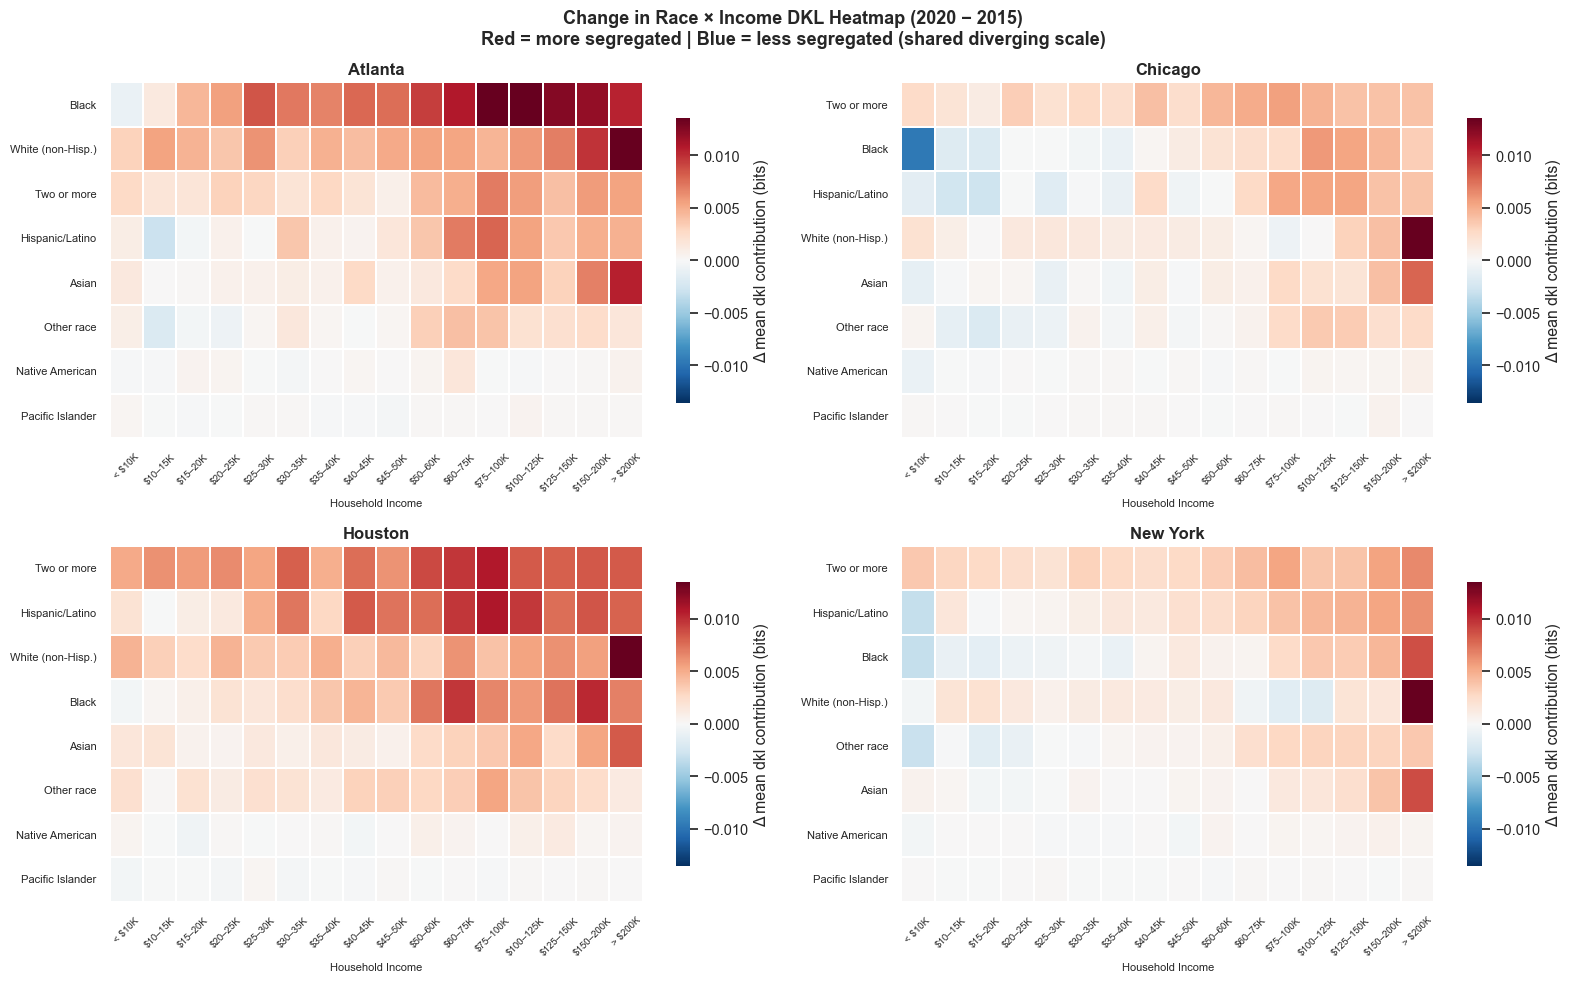

In [11]:
# ── Plot 3: Heatmap — change in race × income DKL matrix (2020 − 2015) ───────
#
# For each (race, income) cell: pop.-weighted mean DKL contribution change.
# Red = more segregated in 2020; Blue = less segregated.

def cell_dkl_matrix(city, year):
    sub = joint[(joint['city_label'] == city) & (joint['year'] == year)].copy()
    sub['w_dkl'] = sub['dkl_2way_jk'] * sub['tract_total']
    agg = (
        sub.groupby(['race_group','income_label'], observed=True)
        .agg(w_dkl=('w_dkl','sum'), w=('tract_total','sum'))
        .reset_index()
    )
    agg['mean_dkl'] = agg['w_dkl'] / agg['w'].replace(0, np.nan)
    return agg.pivot(index='race_group', columns='income_label', values='mean_dkl')


cities_list = sorted(joint['city_label'].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Shared diverging scale across all cities
all_deltas = []
for city in cities_list:
    m15 = cell_dkl_matrix(city, 2015)
    m20 = cell_dkl_matrix(city, 2020)
    all_deltas.append((m20 - m15).values.flatten())
bound = np.nanpercentile(np.concatenate(all_deltas), 99)

for ax, city in zip(axes.flat, cities_list):
    m15 = cell_dkl_matrix(city, 2015)
    m20 = cell_dkl_matrix(city, 2020)
    delta_heat = (m20 - m15).reindex_like(m20)

    # Row order by absolute change
    race_order = delta_heat.abs().sum(axis=1).sort_values(ascending=False).index.tolist()
    delta_heat = delta_heat.loc[race_order]

    sns.heatmap(
        delta_heat, ax=ax,
        cmap='RdBu_r', center=0, vmin=-bound, vmax=bound,
        linewidths=0.3, linecolor='white',
        cbar_kws={'label': 'Δ mean dkl contribution (bits)', 'shrink': 0.8},
    )
    ax.set_title(city, fontsize=12, fontweight='bold')
    ax.set_xlabel('Household Income', fontsize=8)
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelrotation=0, labelsize=8)

fig.suptitle(
    'Change in Race × Income DKL Heatmap (2020 − 2015)\n'
    'Red = more segregated | Blue = less segregated (shared diverging scale)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

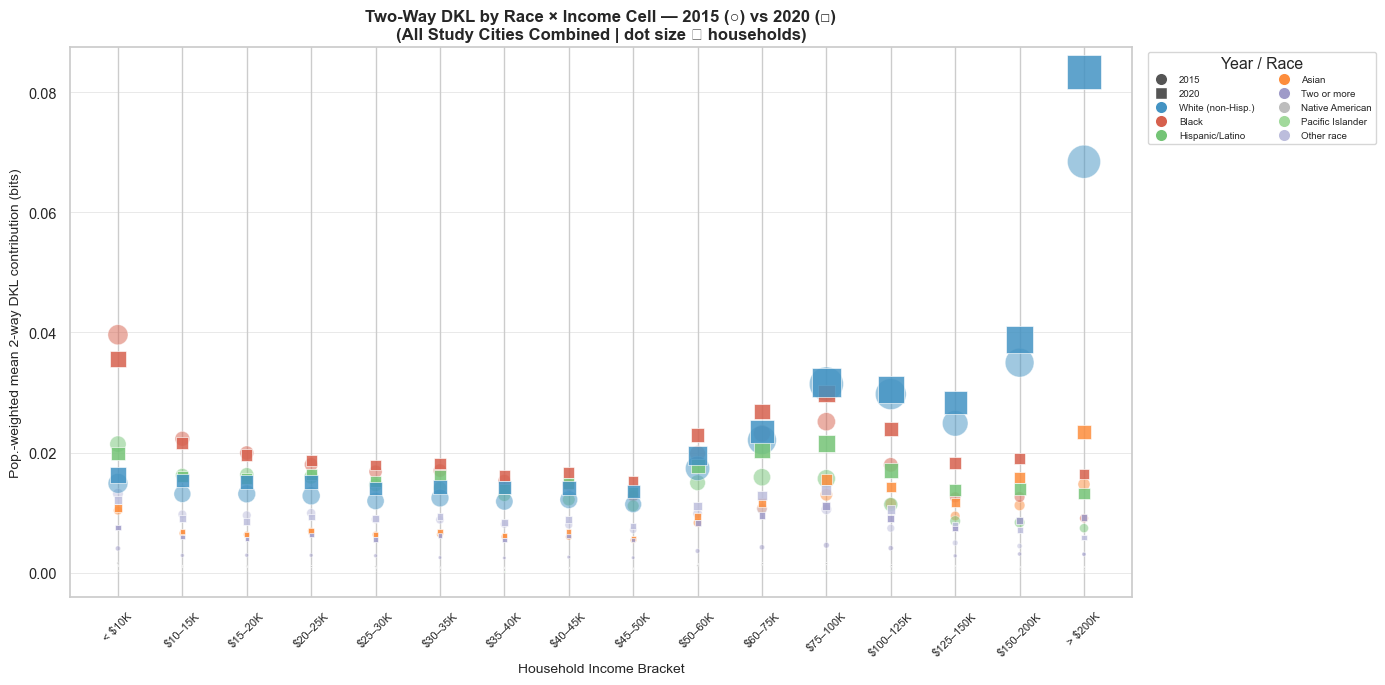

In [12]:
# ── Plot 4: Dot plot — 2-way DKL by (race, income) cell, 2015 vs 2020 ────────
#
# Circles = 2015, squares = 2020. Size ∝ households. Colour = race group.

fig, ax = plt.subplots(figsize=(14, 7))

year_markers = {2015: 'o', 2020: 's'}
year_alpha   = {2015: 0.5, 2020: 0.85}

for year in YEARS:
    dot_sub = joint[joint['year'] == year].copy()
    dot_sub['w_dkl_jk'] = dot_sub['dkl_2way_jk'] * dot_sub['tract_total']
    dot_agg = (
        dot_sub.groupby(['race_group','income_label'], observed=True)
        .agg(
            total_households=('estimate', 'sum'),
            w_dkl=('w_dkl_jk', 'sum'),
            w=('tract_total', 'sum'),
        )
        .reset_index()
    )
    dot_agg['mean_dkl'] = dot_agg['w_dkl'] / dot_agg['w'].replace(0, np.nan)
    dot_agg = dot_agg.dropna(subset=['mean_dkl'])
    max_hh = dot_agg['total_households'].max()

    for race, grp in dot_agg.groupby('race_group'):
        ax.scatter(
            grp['income_label'], grp['mean_dkl'],
            s=grp['total_households'] / max_hh * 600,
            color=RACE_COLORS.get(race, '#888'),
            alpha=year_alpha[year],
            edgecolors='white', linewidths=0.5, zorder=3,
            marker=year_markers[year],
        )

# Legend: year shapes + race colours
legend_els = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor='#555', markersize=9,
           label='2015', markeredgecolor='white'),
    Line2D([0],[0], marker='s', color='w', markerfacecolor='#555', markersize=9,
           label='2020', markeredgecolor='white'),
] + [
    Line2D([0],[0], marker='o', color='w', markerfacecolor=RACE_COLORS.get(r,'#888'),
           markersize=9, label=r, markeredgecolor='white')
    for r in RACE_COLORS
]
ax.legend(handles=legend_els, title='Year / Race', fontsize=7, ncol=2,
          bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_xlabel('Household Income Bracket', fontsize=10)
ax.set_ylabel('Pop.-weighted mean 2-way DKL contribution (bits)', fontsize=10)
ax.set_title(
    'Two-Way DKL by Race × Income Cell — 2015 (○) vs 2020 (□)\n'
    '(All Study Cities Combined | dot size ∝ households)',
    fontsize=12, fontweight='bold'
)
ax.tick_params(axis='x', labelrotation=45, labelsize=8)
ax.grid(axis='y', linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

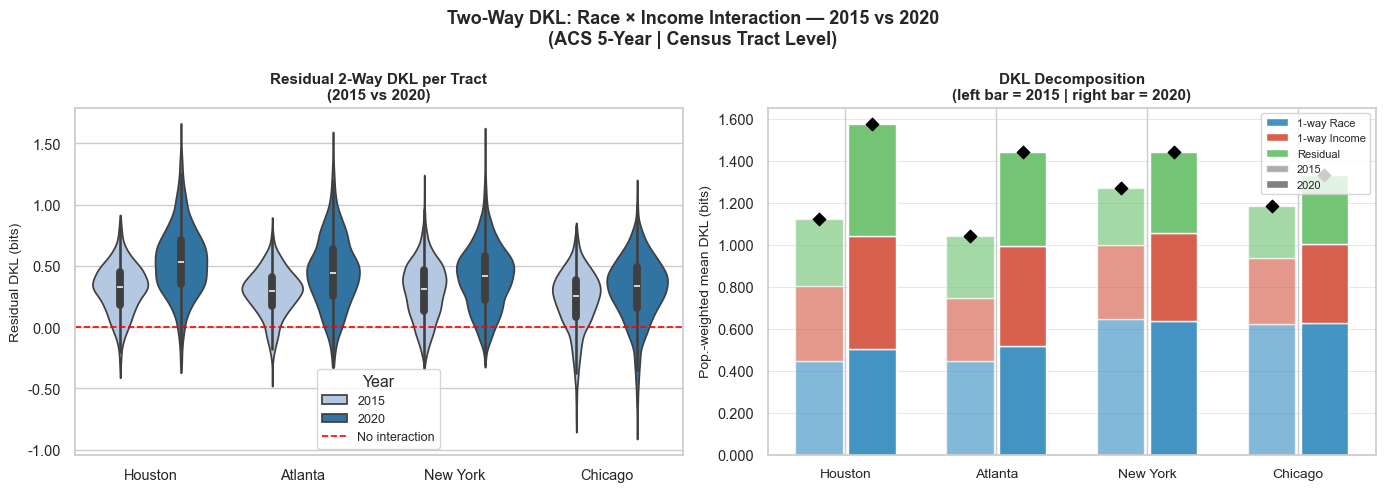

In [13]:
# ── Plot 5: Violin + stacked bars — 2015 vs 2020 ─────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Violin with year hue
ax = axes[0]
plot_data = tract_dkl_all[tract_dkl_all['tract_total'] > 50].copy()
plot_data['year_str'] = plot_data['year'].astype(str)
city_order_v = (
    plot_data[plot_data['year'] == 2020]
    .groupby('city_label')['residual'].median()
    .sort_values(ascending=False).index.tolist()
)

sns.violinplot(
    data=plot_data, x='city_label', y='residual', hue='year_str',
    order=city_order_v,
    palette={'2015': '#aec7e8', '2020': '#1f77b4'},
    inner='box', ax=ax, cut=0,
)
ax.axhline(0, color='red', linestyle='--', linewidth=1.2, label='No interaction')
ax.set_xlabel('')
ax.set_ylabel('Residual DKL (bits)', fontsize=10)
ax.set_title('Residual 2-Way DKL per Tract\n(2015 vs 2020)', fontsize=11, fontweight='bold')
ax.legend(title='Year', fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Panel B: Side-by-side stacked bars (each year as a separate bar per city)
ax = axes[1]
bar_w      = 0.35
year_offset = {2015: -bar_w / 2, 2020: bar_w / 2}
year_alpha  = {2015: 0.65, 2020: 1.0}
x = np.arange(len(city_order_v))

for year in YEARS:
    sub = summary_all[summary_all['year'] == year].set_index('city_label')
    bottom = np.zeros(len(city_order_v))
    for col, color in zip(metric_cols, colors):
        vals = np.array([sub.loc[c, col] if c in sub.index else 0 for c in city_order_v])
        ax.bar(x + year_offset[year], vals, width=bar_w * 0.9, bottom=bottom,
               color=color, alpha=year_alpha[year], edgecolor='white')
        bottom += vals
    totals = [
        sub.loc[c, 'DKL 2-way (joint race×income)'] if c in sub.index else 0
        for c in city_order_v
    ]
    ax.scatter(x + year_offset[year], totals, color='black', zorder=5, s=40, marker='D')

ax.set_xticks(x)
ax.set_xticklabels(city_order_v, fontsize=10)
ax.set_ylabel('Pop.-weighted mean DKL (bits)', fontsize=10)
ax.set_title('DKL Decomposition\n(left bar = 2015 | right bar = 2020)', fontsize=11, fontweight='bold')

legend_els = [Patch(facecolor=c, label=l) for c, l in zip(colors, metric_labels)]
legend_els += [
    Patch(facecolor='grey', alpha=0.65, label='2015'),
    Patch(facecolor='grey', alpha=1.0,  label='2020'),
]
ax.legend(handles=legend_els, fontsize=8, loc='upper right')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

fig.suptitle(
    'Two-Way DKL: Race × Income Interaction — 2015 vs 2020\n'
    '(ACS 5-Year | Census Tract Level)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

In [14]:
# ── Plot 6: Choropleth maps — download shapefiles for both years ──────────────
#
# ACS 2015 uses 2010-definition tracts (TIGER2015).
# ACS 2020 uses 2020-definition tracts (TIGER2020).
# Each year's data is paired with its own shapefiles.

import geopandas as gpd
import contextily as ctx
import requests

SHAPEFILE_CACHE = DATA_DIR / 'two_way_dkl'


def download_tracts(state_fips, year, cache_base):
    sf        = str(state_fips).zfill(2)
    cache_dir = cache_base / f'tracts_{year}'
    cache_dir.mkdir(parents=True, exist_ok=True)
    fpath = cache_dir / f'tl_{year}_{sf}_tract.parquet'
    if fpath.exists():
        return gpd.read_parquet(fpath)
    url = (
        f'https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/'
        f'tl_{year}_{sf}_tract.zip'
    )
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    zip_path = cache_dir / f'tl_{year}_{sf}_tract.zip'
    zip_path.write_bytes(r.content)
    try:
        gdf = gpd.read_file(f'zip://{zip_path}!tl_{year}_{sf}_tract.shp')
    finally:
        zip_path.unlink(missing_ok=True)
    gdf = gdf.rename(columns=str.lower)
    gdf['geoid'] = gdf['geoid'].str.zfill(11)
    gdf = gdf[['geoid', 'geometry']]
    gdf.to_parquet(fpath, index=False)
    return gdf


tracts_by_year = {}
for year in YEARS:
    print(f'Downloading {year} tract shapefiles …')
    gdfs = []
    for sf in study_state_fips:
        try:
            gdfs.append(download_tracts(sf, year, SHAPEFILE_CACHE))
            print(f'  {sf} ✓', end='  ')
        except Exception as e:
            print(f'  {sf} ERROR: {e}')
    tracts_by_year[year] = gpd.GeoDataFrame(
        pd.concat(gdfs, ignore_index=True),
        geometry='geometry', crs='EPSG:4326'
    )
    print(f'\n  → {len(tracts_by_year[year]):,} tracts')

print('Shapefiles ready.')

  13 ✓  

  17 ✓  

  18 ✓  

  34 ✓  

  36 ✓  

  42 ✓  

  48 ✓  

  55 ✓  
  → 23,423 tracts
  13 ✓    17 ✓    18 ✓    34 ✓    36 ✓    42 ✓  

  48 ✓    55 ✓  
  → 27,233 tracts
Shapefiles ready.


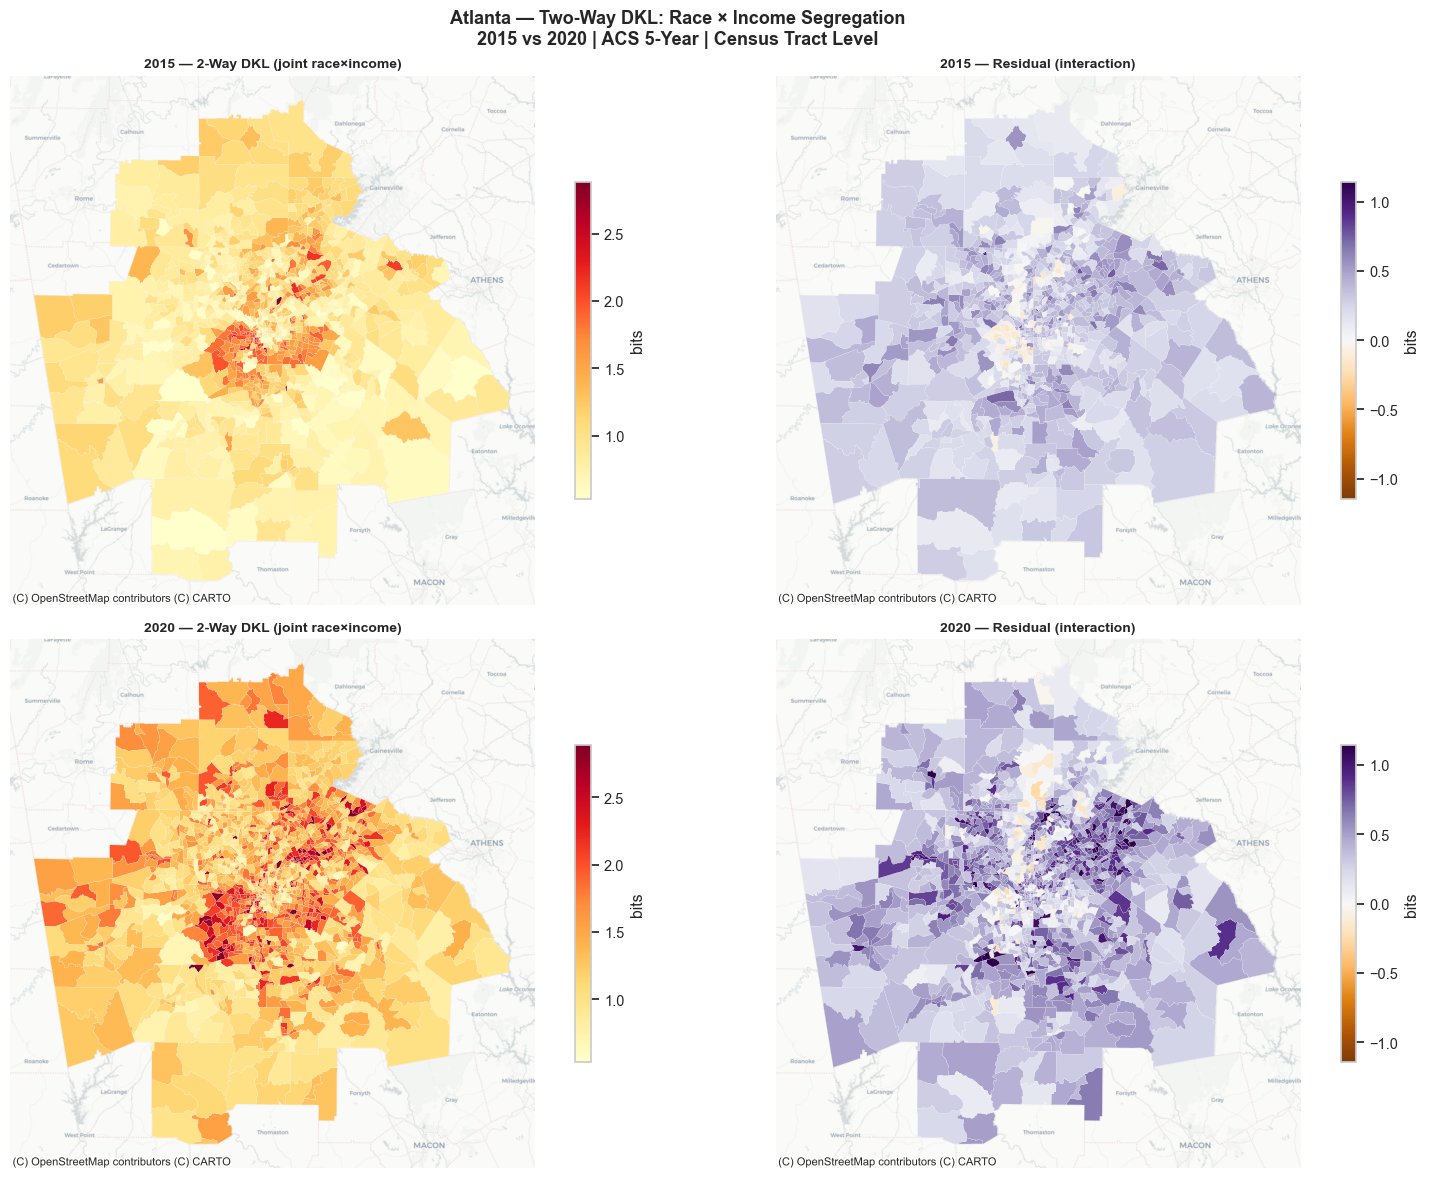

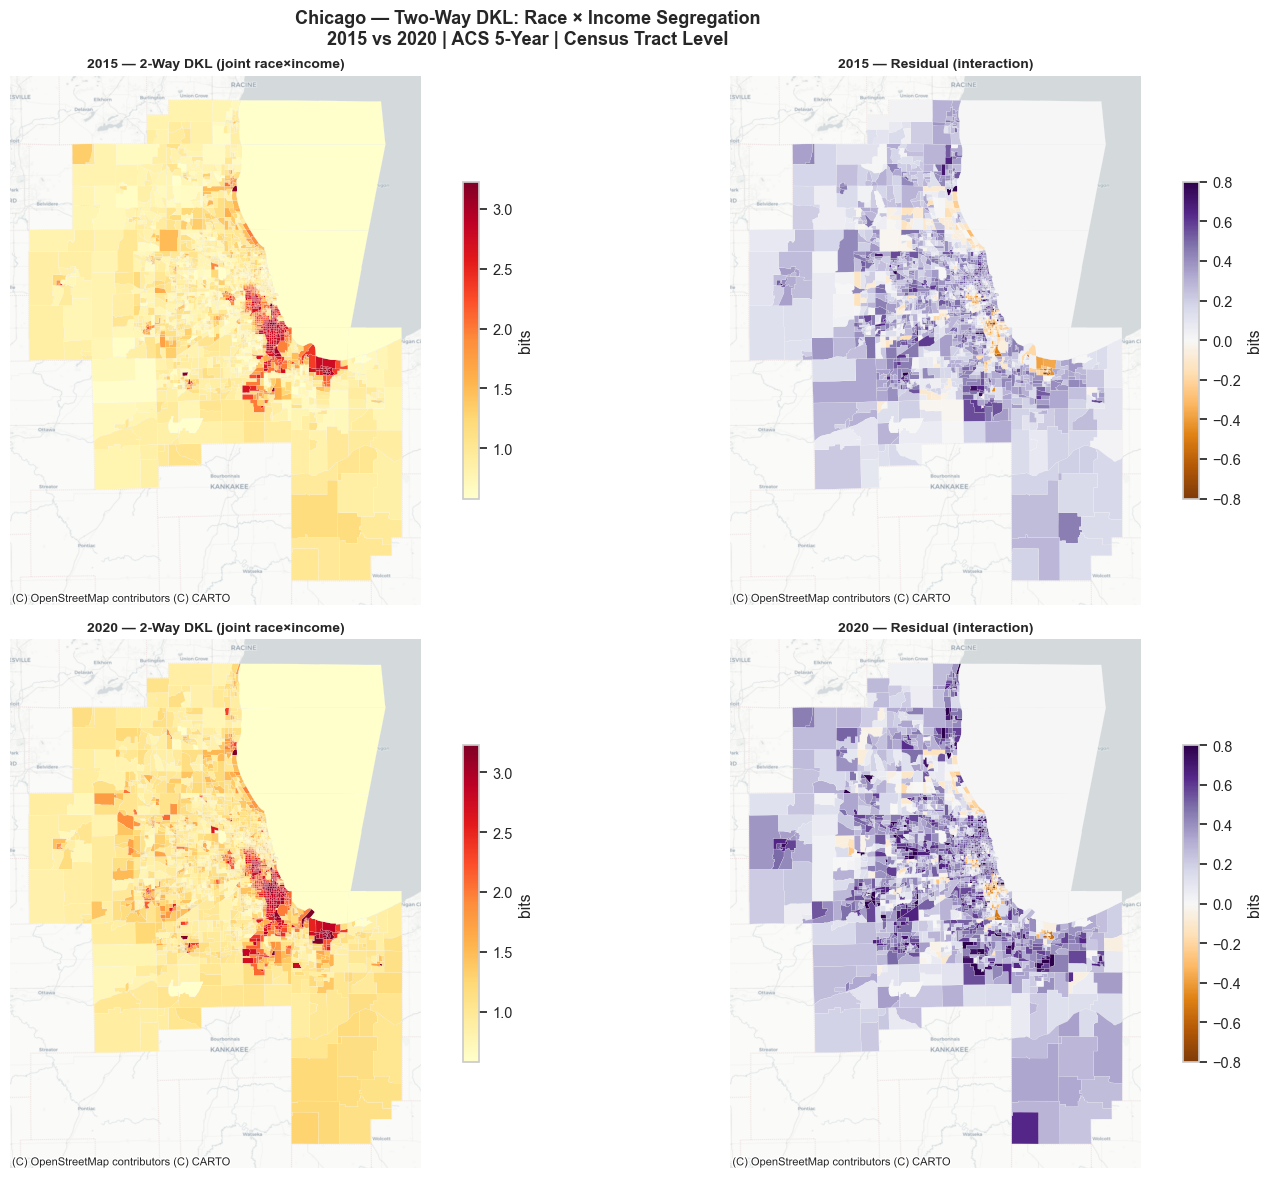

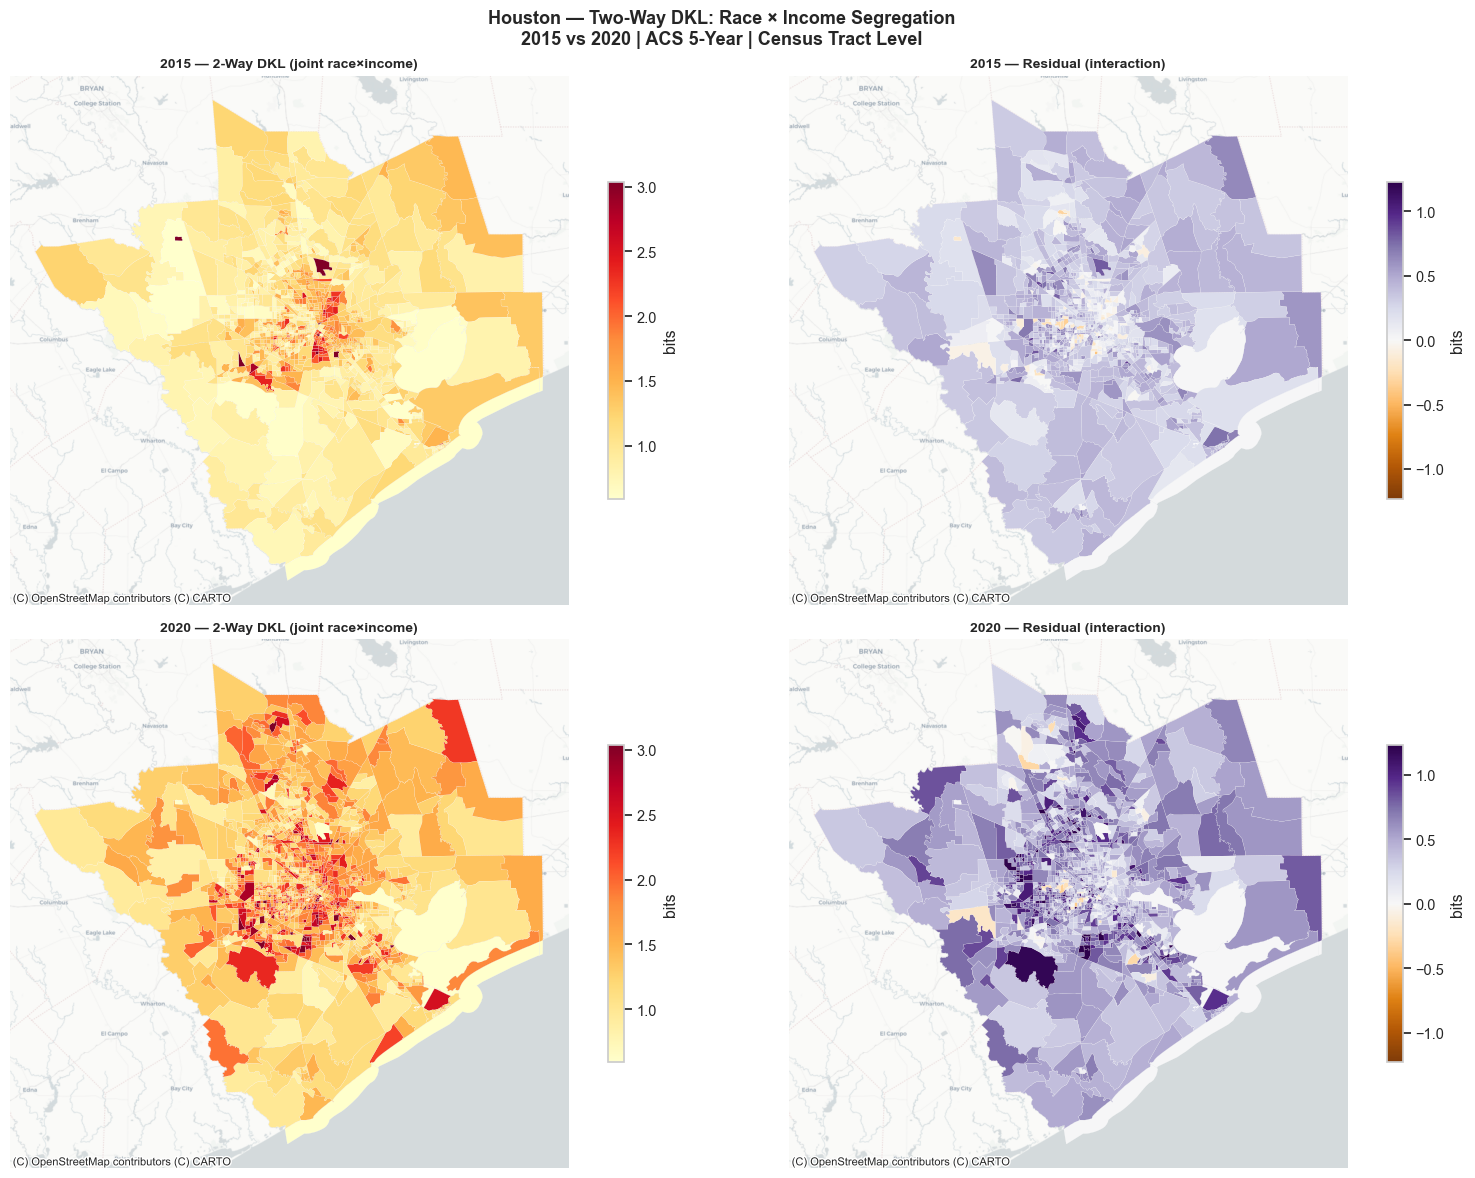

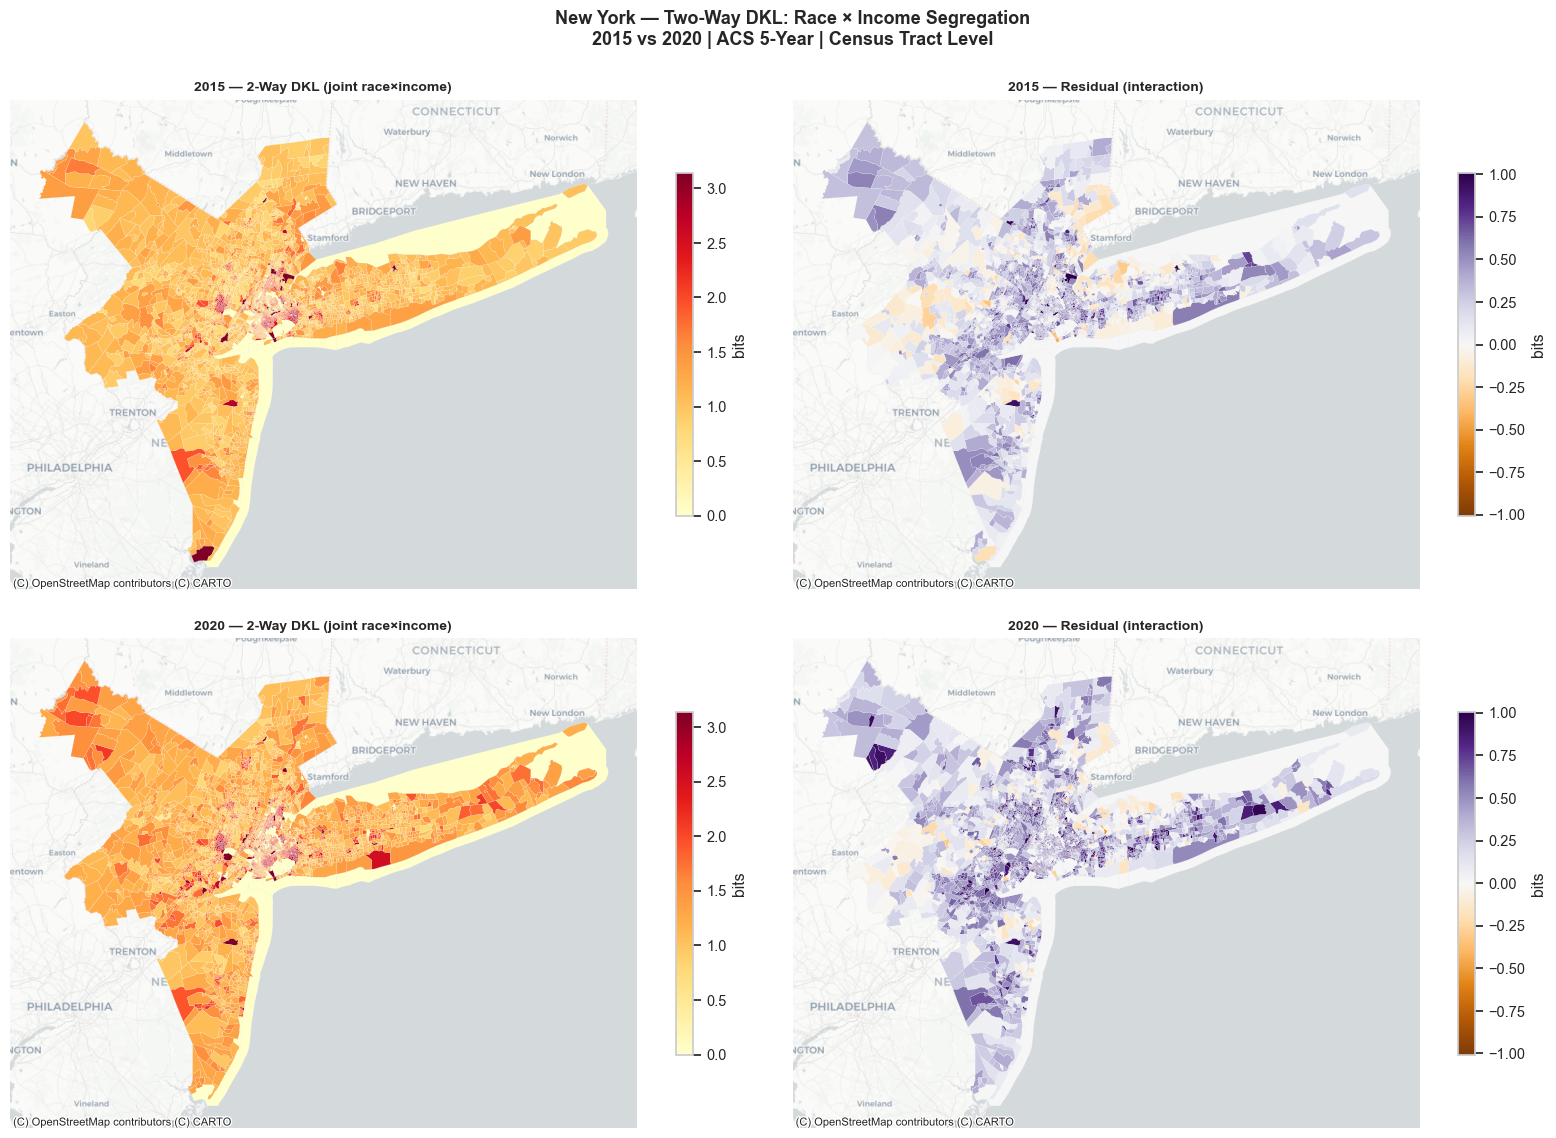

In [15]:
# ── Choropleth: 2×2 grid per city (row = year, col = metric) ─────────────────

COLS   = ['dkl_2way', 'residual']
CTITLES = ['2-Way DKL (joint race×income)', 'Residual (interaction)']
CMAPS  = ['YlOrRd', 'PuOr']

for city in cities_list:
    # Precompute shared colour scales across both years
    vranges = {}
    geo_cache = {}
    for year in YEARS:
        tdkl = tract_dkl_all[
            (tract_dkl_all['year'] == year) & (tract_dkl_all['city_label'] == city)
        ]
        geo = tracts_by_year[year].merge(
            tdkl[['tract_fips', 'dkl_2way', 'residual']],
            left_on='geoid', right_on='tract_fips', how='inner'
        ).to_crs('EPSG:3857')
        geo_cache[year] = geo

    shared = {}
    for col in COLS:
        all_vals = pd.concat([geo_cache[y][col] for y in YEARS if not geo_cache[y].empty])
        vmin = all_vals.quantile(0.01)
        vmax = all_vals.quantile(0.99)
        if col == 'residual':
            bound = max(abs(vmin), abs(vmax))
            vmin, vmax = -bound, bound
        shared[col] = (vmin, vmax)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for ri, year in enumerate(YEARS):
        geo = geo_cache[year]
        if geo.empty:
            continue
        for ci, (col, title, cmap) in enumerate(zip(COLS, CTITLES, CMAPS)):
            ax = axes[ri][ci]
            vmin, vmax = shared[col]
            geo.plot(
                column=col, ax=ax, cmap=cmap,
                vmin=vmin, vmax=vmax,
                linewidth=0.1, edgecolor='white',
                legend=True,
                legend_kwds={'label': 'bits', 'shrink': 0.6, 'orientation': 'vertical'},
                missing_kwds={'color': 'lightgrey'},
            )
            try:
                ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom='auto')
            except Exception:
                pass
            ax.set_axis_off()
            ax.set_title(f'{year} — {title}', fontsize=10, fontweight='bold')

    fig.suptitle(
        f'{city} — Two-Way DKL: Race × Income Segregation\n'
        f'2015 vs 2020 | ACS 5-Year | Census Tract Level',
        fontsize=13, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()